
# Climate Analysis: Vancouver
This notebook analyzes historical climate data for Vancouver, focusing on temperature and precipitation trends, seasonal patterns, and forecasting.

## Objectives
1. Clean and preprocess the data for analysis.
2. Explore trends and seasonal patterns in temperature and precipitation.
3. Perform time-series forecasting using ARIMA and Prophet models.
4. Investigate relationships between additional variables, if available.
5. Generate visualizations for effective interpretation and communication.

---


## Data Cleaning and Preprocessing

In [5]:
# Importing all necessary libraries for data loading, handling, analysis, and visualization

# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Set Seaborn style for nicer visuals

# Time-series modeling and forecasting
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time-series

# Prophet library import is conditional since it may not be installed in this environment
from prophet import Prophet

# Model evaluation
from sklearn.metrics import mean_squared_error  # To evaluate model performance

# Statistical analysis (if needed for additional tests)
from scipy import stats

# Date handling
from datetime import datetime

# Set default figure size for plots to ensure consistency
plt.rcParams["figure.figsize"] = (12, 6)  # Default figure size
plt.rcParams["axes.titlesize"] = 16       # Title font size
plt.rcParams["axes.labelsize"] = 14       # Axis label font size

# Verification of library import success
"All necessary libraries imported successfully."

# Load the dataset
data_file_path = '/Users/shariq/Desktop/Project/data/weatherstats_vancouver_normal_monthly.csv'
data = pd.read_csv(data_file_path)

# Inspect the first few rows
data.head()

,date,max_dew_point_v,max_dew_point_s,max_dew_point_c,max_dew_point_d,max_relative_humidity_v,max_relative_humidity_s,max_relative_humidity_c,max_relative_humidity_d,max_temperature_v,...,snow_c,snow_d,snow_on_ground_v,snow_on_ground_s,snow_on_ground_c,snow_on_ground_d,solar_radiation_v,solar_radiation_s,solar_radiation_c,solar_radiation_d
0,2024-11-01,6.20,1.46,30.0,1994-11-01 2023-11-01,94.32,3.60,30.0,1994-11-01 2023-11-01,9.37,...,30,1994-11-01 2023-11-01,0.3,0.72,24.0,1994-11-01 2022-11-01,NaN,NaN,NaN,NaN
1,2024-10-01,9.68,1.22,30.0,1994-10-01 2023-10-01,94.03,4.02,30.0,1994-10-01 2023-10-01,13.60,...,30,1994-10-01 2023-10-01,0.0,0.00,23.0,1994-10-01 2016-10-01,NaN,NaN,NaN,NaN
2,2024-09-01,13.28,1.12,30.0,1994-09-01 2023-09-01,92.44,3.82,30.0,1994-09-01 2023-09-01,19.08,...,30,1994-09-01 2023-09-01,0.0,0.00,21.0,1994-09-01 2016-09-01,NaN,NaN,NaN,NaN
3,2024-08-01,15.19,1.25,30.0,1994-08-01 2023-08-01,89.05,4.54,30.0,1994-08-01 2023-08-01,22.57,...,30,1994-08-01 2023-08-01,0.0,0.00,22.0,1994-08-01 2016-08-01,NaN,NaN,NaN,NaN
4,2024-07-01,14.78,1.11,30.0,1994-07-01 2023-07-01,86.64,4.48,30.0,1994-07-01 2023-07-01,22.67,...,30,1994-07-01 2023-07-01,0.0,0.00,23.0,1994-07-01 2017-07-01,NaN,NaN,NaN,NaN


In [6]:

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Convert all relevant columns to numeric to handle any non-numeric values
for col in data.columns:
    if col.startswith(('min_', 'max_', 'temperature', 'humidity', 'precipitation', 'wind_speed')):
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculate averages for min/max pairs
columns_to_drop = []
for col in data.columns:
    if col.startswith('min_') and col.replace('min_', 'max_') in data.columns:
        base_name = col.replace('min_', '')
        data[f'avg_{base_name}'] = (data[col] + data[f'max_{base_name}']) / 2
        columns_to_drop.extend([col, f'max_{base_name}'])

# Drop temperature min/max columns and irrelevant columns
columns_to_drop.extend([col for col in data.columns if col.endswith('_c')])
data.drop(columns=columns_to_drop, inplace=True)

# Drop rows with missing values in key columns
cleaned_data = data.dropna(subset=['date', 'avg_temperature_v', 'precipitation_v']).set_index('date')

# Check cleaned data
cleaned_data.info()
cleaned_data.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-11-01 to 1941-08-01
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   precipitation_v          1000 non-null   float64
 1   precipitation_s          1000 non-null   float64
 2   precipitation_d          0 non-null      float64
 3   rain_v                   1000 non-null   float64
 4   rain_s                   1000 non-null   float64
 5   rain_d                   1000 non-null   object 
 6   snow_v                   1000 non-null   float64
 7   snow_s                   1000 non-null   float64
 8   snow_d                   1000 non-null   object 
 9   snow_on_ground_v         827 non-null    float64
 10  snow_on_ground_s         827 non-null    float64
 11  snow_on_ground_d         827 non-null    object 
 12  solar_radiation_v        0 non-null      float64
 13  solar_radiation_s        0 non-null      float64
 14  solar_

,precipitation_v,precipitation_s,precipitation_d,rain_v,rain_s,snow_v,snow_s,snow_on_ground_v,snow_on_ground_s,solar_radiation_v,...,avg_dew_point_d,avg_relative_humidity_v,avg_relative_humidity_s,avg_relative_humidity_d,avg_temperature_v,avg_temperature_s,avg_temperature_d,avg_wind_speed_v,avg_wind_speed_s,avg_wind_speed_d
count,1000.000000,1000.000000,0.0,1000.00000,1000.000000,1000.000000,1000.000000,827.000000,827.000000,0.0,...,0.0,851.000000,851.000000,0.0,1000.000000,1000.000000,0.0,851.000000,851.000000,0.0
mean,92.818390,39.332480,NaN,88.80240,39.959220,3.641430,5.447260,0.277872,0.560133,NaN,...,NaN,78.748543,3.301234,NaN,10.007725,1.233850,NaN,12.963290,1.837891,NaN
std,48.230084,14.150806,NaN,44.43504,14.716424,6.017777,8.018831,0.517497,0.990203,NaN,...,NaN,4.732179,0.856743,NaN,5.124897,0.450074,NaN,1.113735,0.568728,NaN
min,20.160000,7.950000,NaN,20.16000,6.200000,0.000000,0.000000,0.000000,0.000000,NaN,...,NaN,71.095000,0.000000,NaN,1.825000,0.650000,NaN,10.825000,0.000000,NaN
25%,49.650000,27.467500,NaN,49.65000,27.410000,0.000000,0.000000,0.000000,0.000000,NaN,...,NaN,74.087500,2.867500,NaN,5.671250,0.950000,NaN,12.047500,1.485000,NaN
50%,87.880000,36.350000,NaN,85.69000,36.315000,0.070000,0.360000,0.000000,0.000000,NaN,...,NaN,78.180000,3.405000,NaN,9.815000,1.085000,NaN,12.970000,1.785000,NaN
75%,125.795000,51.917500,NaN,120.47000,52.882500,5.415000,10.400000,0.300000,0.760000,NaN,...,NaN,83.507500,3.830000,NaN,15.066250,1.480000,NaN,13.795000,2.265000,NaN
max,214.670000,73.370000,NaN,208.68000,77.240000,28.670000,29.640000,2.500000,4.190000,NaN,...,NaN,88.790000,5.160000,NaN,18.375000,3.490000,NaN,16.920000,3.245000,NaN


## Exploratory Data Analysis (EDA)

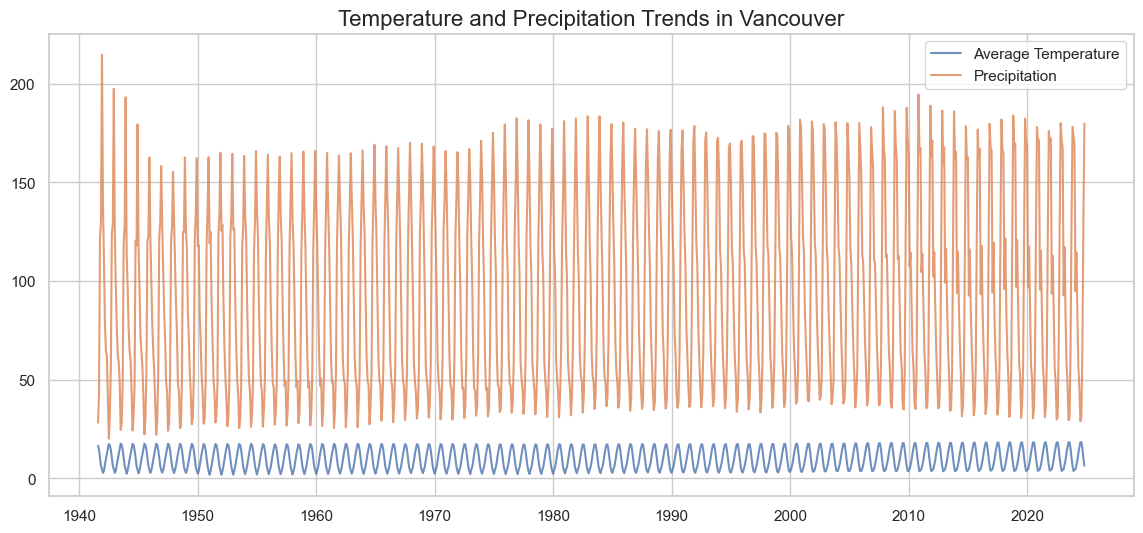

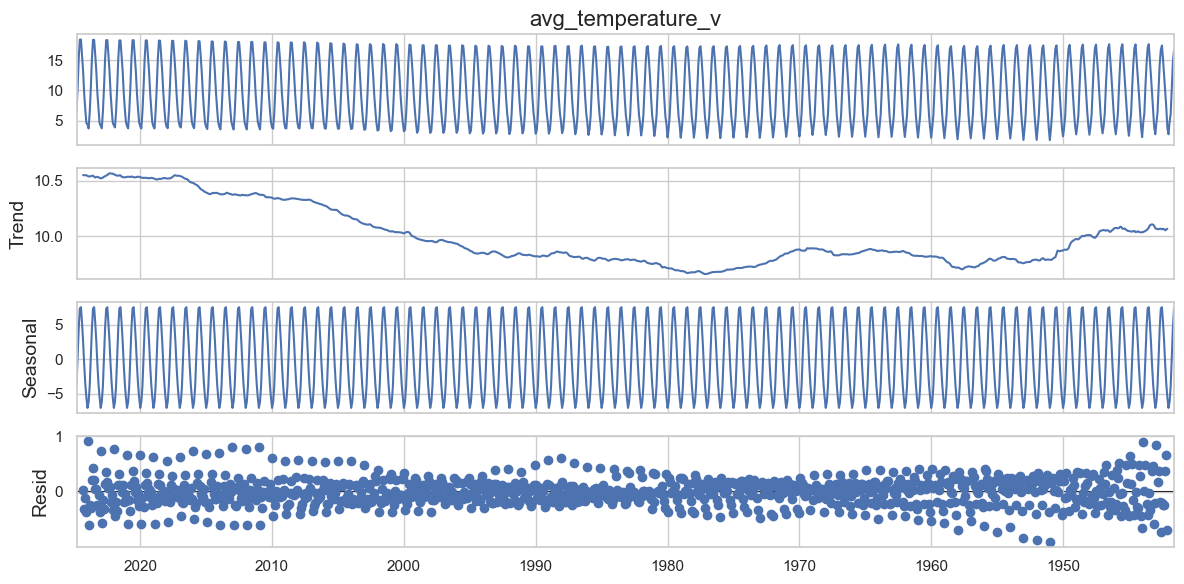

ValueError: could not convert string to float: '1994-11-01 2023-11-01'

In [7]:

# Visualize trends in temperature and precipitation
plt.figure(figsize=(14, 6))
plt.plot(cleaned_data['avg_temperature_v'], label='Average Temperature', alpha=0.8)
plt.plot(cleaned_data['precipitation_v'], label='Precipitation', alpha=0.8)
plt.title('Temperature and Precipitation Trends in Vancouver')
plt.legend()
plt.show()

# Seasonal decomposition of temperature
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(cleaned_data['avg_temperature_v'], model='additive', period=12)
decomposition.plot()
plt.show()

# Correlation heatmap
corr = cleaned_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Time-Series Modeling and Forecasting

In [ ]:

# ARIMA model for temperature forecasting
from statsmodels.tsa.arima.model import ARIMA

temperature_model = ARIMA(cleaned_data['avg_temperature_v'], order=(1, 1, 1))
temperature_results = temperature_model.fit()

# Forecast future values
forecast_steps = 12  # Forecast for one year
forecast = temperature_results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(cleaned_data['avg_temperature_v'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Temperature Forecast with ARIMA')
plt.legend()
plt.show()


In [4]:

# Prophet model for precipitation forecasting
prophet_data = cleaned_data.reset_index()[['date', 'precipitation_v']]
prophet_data.columns = ['ds', 'y']

model = Prophet()
model.fit(prophet_data)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title('Precipitation Forecast with Prophet')
plt.show()


NameError: name 'cleaned_data' is not defined